#### Created weight file  The first one (from mesh files) didn't work

```
ESMF_RegridWeightGen --source /glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc --destination /glade/campaign/cesm/cesmdata/inputdata/share/meshes/fv0.9x1.25_141008_polemod_ESMFmesh.nc --weight /glade/work/wwieder/map_ne30pg3_to_fv0.9x1.25_nomask_c250108.nc --method conserve
```

#### This sencond one (from scripgrid files) has the right dimensions for dst_grid_dims (192x288) 
TODO:
- what's the correct method here?
- appropriate to use scripgrids
- provide these for more common resolutions?
```
ESMF_RegridWeightGen --source /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/ne30pg3_scrip_170611.nc --destination /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv0.9x1.25_141008.nc --weight /glade/work/wwieder/map_ne30pg3_to_fv0.9x1.25_scripgrids_nomask_c250108.nc --method conserve2nd --ignore_unmapped --ignore_degenerate --pole none
```

Trying to get the pole in lat (as in the FV09 grid), didn't work.  
adding pole all required a method other that conserve2nd
**Currently using this**
```
ESMF_RegridWeightGen --source /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/ne30pg3_scrip_170611.nc --destination /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv0.9x1.25_141008.nc --weight /glade/work/wwieder/map_ne30pg3_to_fv0.9x1.25_scripgrids_conserve_nomask_c250108.nc --method conserve
```

```
ESMF_RegridWeightGen --source /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/ne30pg3_scrip_170611.nc --destination /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv0.9x1.25_141008.nc --weight /glade/work/wwieder/map_ne30pg3_to_fv0.9x1.25_scripgrids_nomask_c250108.nc --method bilinear --pole all --ignore_unmapped
```


#### Also added area and land frac to single variable time series
```
ncks -A -v area,landfrac,landmask /glade/derecho/scratch/hannay/archive/b.e30_beta04.BLT1850.ne30_t232_wgx3.121/lnd/hist/b.e30_beta04.BLT1850.ne30_t232_wgx3.121.clm2.h0.0012-10.nc /glade/derecho/scratch/wwieder/ADF/b.e30_beta04.BLT1850.ne30_t232_wgx3.121/climo/b.e30_beta04.BLT1850.ne30_t232_wgx3.121_GPP_climo.nc
```

In [1]:
import os, sys
import shutil
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import xesmf as xe
import regrid_se_to_fv

# Helpful for plotting only
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import uxarray as ux  #need npl 2024a or later
import geoviews.feature as gf

#### Conservative regridding
- set missing values to zero
- Weight fluxes by source landfrac, 
- Regrid, then
- Divide by regridded landfrac
- Calculate global and regional sums
- For plotting add destination landmask to get rid of bloated coastlines

#### At the end of the day we want to write out a destination grid .nc file with:
- regridded field
- regridded land frac
- wall to wall area (currently from CAM history file)
- destination grid land mask


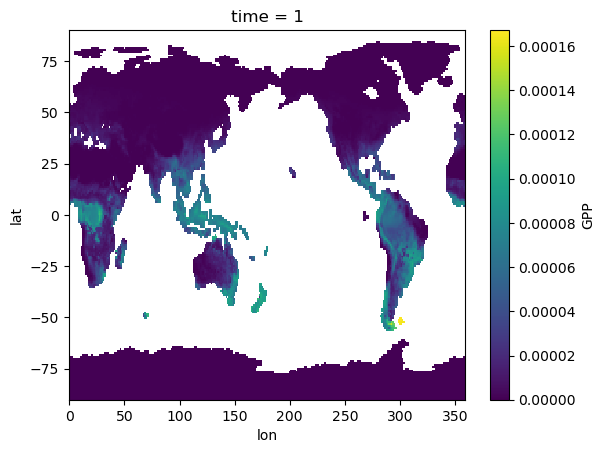

In [2]:
# Dummy source file to regrid (for now this can be from climo files made by adf)
gppfile='/glade/derecho/scratch/wwieder/ADF/b.e30_beta04.BLT1850.ne30_t232_wgx3.121/climo/b.e30_beta04.BLT1850.ne30_t232_wgx3.121_GPP_climo.nc'
ds_con = xr.open_dataset(gppfile)

# Weighting file needed for regridding, keep this hard coded for now.
con_weight_file = "/glade/work/wwieder/map_ne30pg3_to_fv0.9x1.25_scripgrids_conserve_nomask_c250108.nc"

# dummy destination grid
fv_t232_file = '/glade/derecho/scratch/wwieder/ctsm5.3.018_SP_f09_t232_mask/run/ctsm5.3.018_SP_f09_t232_mask.clm2.h0.0001-01.nc'
fv_t232 = xr.open_dataset(fv_t232_file)

# Fill in  missing values with zeros
ds_con['GPP'] = ds_con['GPP'].fillna(0) 
ds_con['landfrac']= ds_con['landfrac'].fillna(0)  
ds_con['GPP'] = ds_con.GPP * ds_con.landfrac # weight flux by land frac

# not used for actually regridding
#ds_con['test'] = ((ds_con.GPP)*0+1.)
#ds_con['test'] = ds_con.test * ds_con.landfrac

# These are the calls to regrid the souce data
regridder = regrid_se_to_fv.make_se_regridder(weight_file=con_weight_file, 
                                              s_data = ds_con.landmask.isel(time=0), 
                                              d_data = fv_t232.landmask,
                                              Method = 'coservative',
                                              )
ds_out_con = regrid_se_to_fv.regrid_se_data_conservative(regridder, ds_con).load()

# Post processing to finish the conversion correctly:
ds_out_con['GPP'] = (ds_out_con.GPP / ds_out_con.landfrac)
#ds_out_con['test'] = (ds_out_con.test / ds_out_con.landfrac)

# drop time variables
ds_out_con['landfrac'] = ds_out_con['landfrac'].isel(time=0) 
ds_out_con['area'] = ds_out_con['area'].isel(time=0) 
ds_out_con['landmask'] = ds_out_con['landmask'].isel(time=0) 

# TODO, add a global area and landmask field from the destination grid for calculating sums and plotting.
# TODO save this as a .nc file
# TODO, drop the test field from this once integrated into ADF
# Quick check of results
ds_out_con.GPP.isel(time=0).plot() ;

#### Bilinear regridding
- Include a mask
- set `skipna=True, na_thres=1` in xEMSF regridder
- Weighting fluxes landfrac degrades results
- destination Mask where destination landfrac > 0 to avoid bloated coastlines

In [3]:
bilin_weight_file = "/glade/work/wwieder/map_ne30pg3_to_fv0.9x1.25_scripgrids_bilinear_nomask_c250108.nc"
ds_bilin = xr.open_dataset(gppfile)
ds_bilin['test'] = ((ds_bilin.GPP)*0+1.)
ds_bilin['mask'] = ds_bilin.landmask 

# Read in weight file and regrid
regridder = regrid_se_to_fv.make_se_regridder(weight_file=bilin_weight_file, 
                                              s_data = ds_con.landmask.isel(time=0), 
                                              d_data = fv_t232.landmask,
                                              Method='bilinear',
                                             )
ds_out_bilin = regrid_se_to_fv.regrid_se_data_bilinear(regridder, ds_bilin).load()
ds_out_bilin['landfrac'] = ds_out_bilin['landfrac'].isel(time=0) 
ds_out_bilin['area'] = ds_out_bilin['area'].isel(time=0) 
ds_out_bilin['landmask'] = ds_out_bilin['landmask'].isel(time=0) 

----
#### Quick look at g17 vs. t232 masks and regridded results

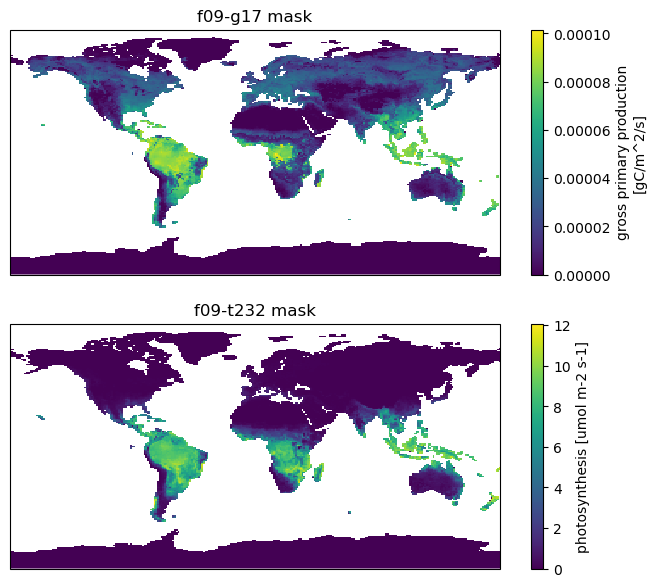

In [4]:
mesh0 = '/glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc'
ds0 = ux.open_dataset(mesh0, gppfile)
ds0['test'] = (ds0.GPP)*0+1

mesh1 = '/glade/campaign/cesm/cesmdata/inputdata/share/meshes/fv0.9x1.25_141008_ESMFmesh.nc'
fv_g17_file = '/glade/derecho/scratch/oleson/ANALYSIS/climo/ctsm53n04ctsm52028_f09_hist/ctsm53n04ctsm52028_f09_hist_annT_1850.nc'
fv_g17 = xr.open_dataset(fv_g17_file)
ux_g17 = ux.open_dataset(mesh1, fv_g17_file)

#CLM output already has area masked
fv_cam_file = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/AREA/b.e21.BSSP370smbb.f09_g17.LE2-1301.020.cam.h0.AREA.209501-210012.nc'
fv_cam_area = xr.open_dataset(fv_cam_file)['AREA'].isel(time=0)*1e-6 # convert m2 to km2
fv_cam_area.attrs['units'] = fv_t232['area'].attrs['units']

# Plot the two masks
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw=dict(projection=ccrs.PlateCarree()),
                        figsize=(8,7))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

fv_g17.GPP.isel(time=0).plot(ax=axs[0])
axs[0].set_title('f09-g17 mask')

fv_t232.FPSN.isel(time=0).plot(ax=axs[1])
axs[1].set_title('f09-t232 mask') ;


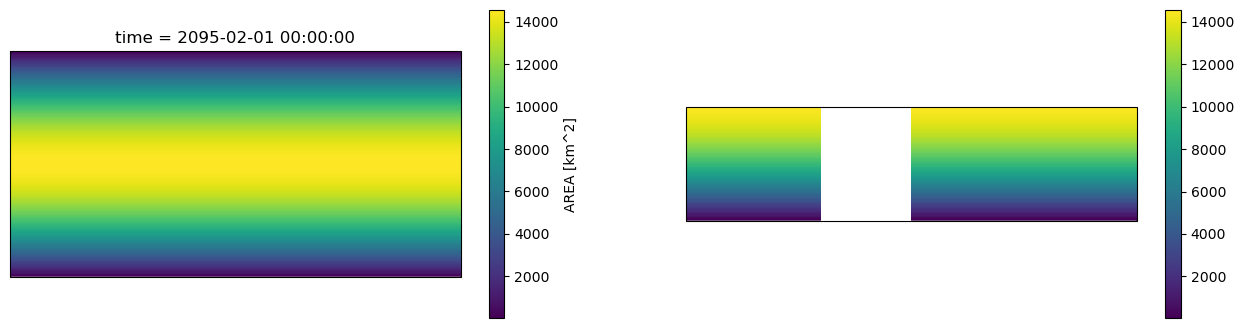

In [5]:
# calculate are directly from weight file.
ds_weight = xr.open_dataset(con_weight_file)

SHR_CONST_REARTH  = 6.37122e3    # radius of earth ~ km
area_raw = ds_weight.area_b * (SHR_CONST_REARTH**2)
area_shape = xr.DataArray(area_raw.data.reshape(192,288), dims=("lat", "lon"))
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw=dict(projection=ccrs.PlateCarree()),
                        figsize=(16,4))
axs=axs.flatten()
(fv_cam_area).plot(ax=axs[0]) ;
# fv_t232.area.plot(ax=axs[1]) ;
area_shape.plot(ax=axs[1], x='lon',y='lat');

In [6]:
# add wall to wall area to clm history file
fv_cam_area['lat'] = fv_t232.lat
fv_cam_area['lon'] = fv_t232.lon
fv_t232['area'] = fv_cam_area

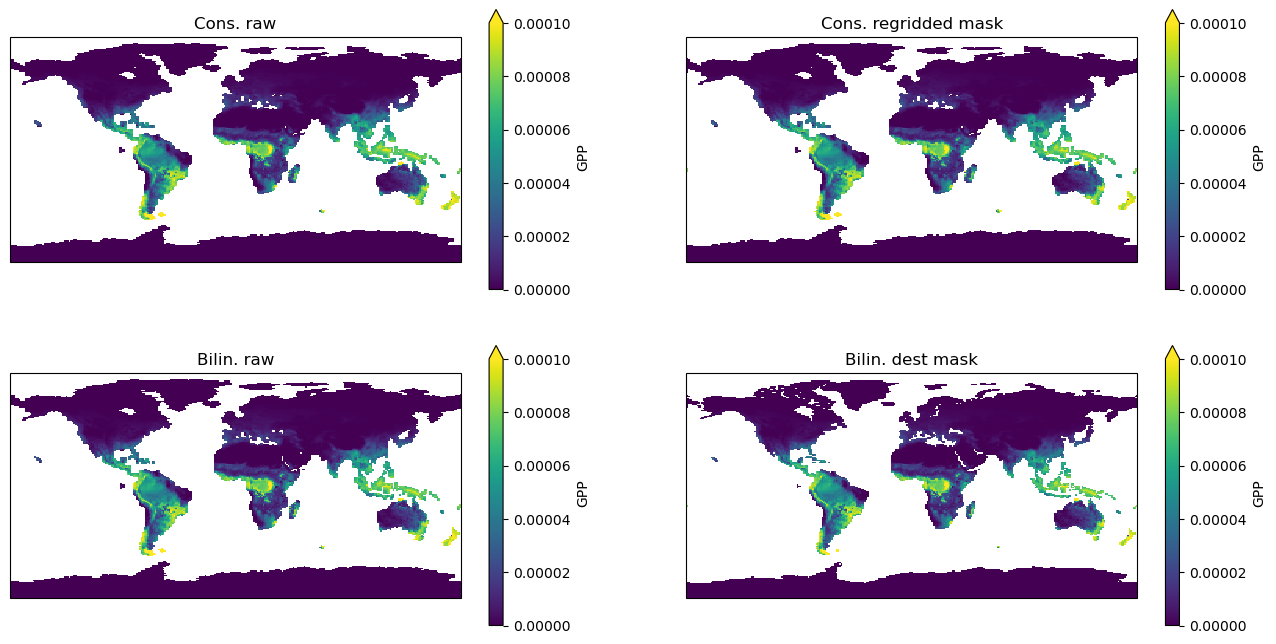

In [7]:
# lats are not the same on destination grid, adjusting now
ds_out_con['lat'] = fv_t232.lat
ds_out_bilin['lat'] = fv_t232.lat

# Plot the two masks
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw=dict(projection=ccrs.PlateCarree()),
                        figsize=(16,8))

axs=axs.flatten()
ds_out_con.GPP.isel(time=0).plot(ax=axs[0],vmin=0,vmax=1e-4)
axs[0].set_title('Cons. raw')

ds_out_con.GPP.isel(time=0).where(ds_out_con.landfrac > 0).plot(ax=axs[1],vmin=0,vmax=1e-4)
axs[1].set_title('Cons. regridded mask')

ds_out_bilin.GPP.isel(time=0).plot(ax=axs[2],vmin=0,vmax=1e-4)
axs[2].set_title('Bilin. raw')

ds_out_bilin.GPP.isel(time=0).where(fv_t232.landfrac>0).plot(ax=axs[3],vmin=0,vmax=1e-4)
axs[3].set_title('Bilin. dest mask') ;

## Go ahead and apply the mask based on destination grid?
# Currently conservative only has mask based on remapped landfrac
# Bilinear with destination landfrac mask
ds_out_con = ds_out_con.where(ds_out_con.landfrac>0)
ds_out_bilin = ds_out_bilin.where(fv_t232.landfrac>0)

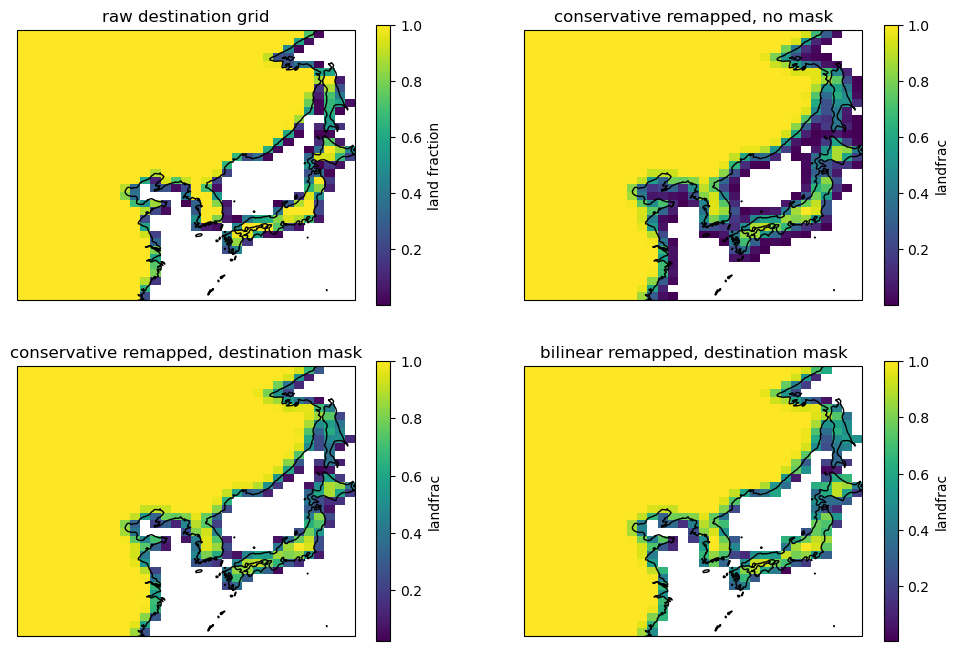

In [8]:
lon_bounds = (105, 145)
lat_bounds = (25, 58)
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw=dict(projection=ccrs.PlateCarree()),
                        figsize=(12,8))
axs=axs.flatten()

fv_t232.landfrac \
  .sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0],lat_bounds[1]))\
  .plot(ax=axs[0]) 
axs[0].set_title('raw destination grid') ;

ds_out_con.landfrac \
  .sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0],lat_bounds[1]))\
  .plot(ax=axs[1]) 
axs[1].set_title('conservative remapped, no mask')

ds_out_con.landfrac.where(fv_t232.landfrac>0) \
  .sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0],lat_bounds[1]))\
  .plot(ax=axs[2]) 
axs[2].set_title('conservative remapped, destination mask')

ds_out_bilin.landfrac \
  .sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0],lat_bounds[1]))\
  .plot(ax=axs[3]) 
axs[3].set_title('bilinear remapped, destination mask')

for a in axs:
    a.coastlines() ;

In [9]:
print(ds_out_con.landfrac.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0],lat_bounds[1])).sum().values)
print(ds_out_con.landfrac.where(fv_t232.landfrac>0) \
      .sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0],lat_bounds[1])).sum().values)

768.7117
766.0552


In [10]:
# look a grid structure for ne30
#projection = ccrs.PlateCarree()
#ds0["area"].plot.polygons(projection=projection)

------------
### Check global sums
----------

In [11]:
# Not the right way to calculate annual mean from monthly climo, but it works

spy = 3600 * 24 * 365
km2_m2 = 1e6
g_Pg = 1e-15

print('source, ne30 land area = ' + str(((ds_bilin.area * ds_bilin.landfrac).sum()*1e-6).values)+ ' 1e6 km2')
print('destination, f09_t232 land area = ' + str(((fv_t232.area * fv_t232.landfrac).sum()*1e-6).values))
print('conservative regridded land area = ' + str(((fv_t232.area * ds_out_con.landfrac).sum()*1e-6).values)+ ' 1e6 km2')
print('bilinear regridded land area = ' + str(((fv_t232.area * ds_out_bilin.landfrac).sum()*1e-6).values)+ ' 1e6 km2')
print()

GPP_sum = ((ds_bilin.GPP * ds_bilin.area * ds_bilin.landfrac).mean('time') * spy * km2_m2).sum() * g_Pg
GPP_sum_regrid1 = ((ds_out_con.GPP * fv_t232.area * fv_t232.landfrac).mean('time') * spy * km2_m2).sum() * g_Pg
GPP_sum_regrid1B = ((ds_out_con.GPP * fv_t232.area * ds_out_con.landfrac).mean('time') * spy * km2_m2).sum() * g_Pg
GPP_sum_regrid2 = ((ds_out_bilin.GPP * fv_t232.area * fv_t232.landfrac).mean('time') * spy * km2_m2).sum() * g_Pg

print('orig ne30 GPP = ' + str(np.round(GPP_sum.values,3))+ ' Pg C, globally')
print('conservative regridded GPP, t232 landfrac = ' + str(np.round(GPP_sum_regrid1.values,3)))
print('conservative regridded GPP, regridded landfrac = ' + str(np.round(GPP_sum_regrid1B.values,3)))
print('bilinear regridded GPP, t232 landfrac = ' + str(np.round(GPP_sum_regrid2.values,3)))

# best results when using regridded flux and destination grid area and landfrac

source, ne30 land area = 1790.2597119999998 1e6 km2
destination, f09_t232 land area = 149.189408
conservative regridded land area = 149.18937599999998 1e6 km2
bilinear regridded land area = 151.03866439950346 1e6 km2

orig ne30 GPP = 104.964 Pg C, globally
conservative regridded GPP, t232 landfrac = 104.92
conservative regridded GPP, regridded landfrac = 104.963
bilinear regridded GPP, t232 landfrac = 105.007


In [12]:
ds_out_con

<xarray.Dataset> Size: 6MB
Dimensions:   (time: 12, lat: 192, lon: 288)
Coordinates:
  * time      (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat       (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Data variables:
    GPP       (time, lat, lon) float32 3MB 0.0 0.0 0.0 0.0 ... nan nan nan nan
    area      (lat, lon) float32 221kB 1.236e+04 1.236e+04 1.236e+04 ... nan nan
    landfrac  (lat, lon) float32 221kB 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan
    landmask  (lat, lon) float64 442kB 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan
    test      (time, lat, lon) float32 3MB 1.0 1.0 1.0 1.0 ... nan nan nan nan
Attributes:
    regrid_method:  coservative

1.0


array(1.00000006)

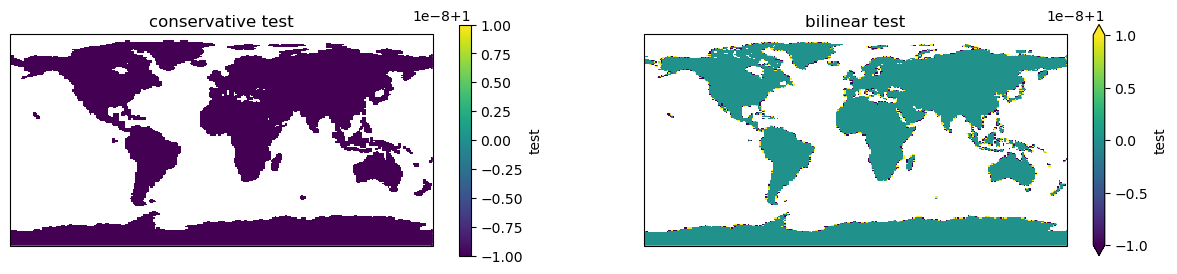

In [13]:
# Check to see if you get appropriate test values around the coast
# should be identically 1, but maybe this is within rounding errors for single precision data?

fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw=dict(projection=ccrs.PlateCarree()),
                        figsize=(15,3))
axs=axs.flatten()
ds_out_con.test.isel(time=0).plot(vmin=1-1e-8, vmax=1+1e-8, ax=axs[0])
ds_out_bilin.test.isel(time=0).plot(vmin=1-1e-8, vmax=1+1e-8, ax=axs[1])
axs[0].set_title('conservative test')
axs[1].set_title('bilinear test') ;
print(ds_out_con.test.min().values)
ds_out_bilin.test.max().values

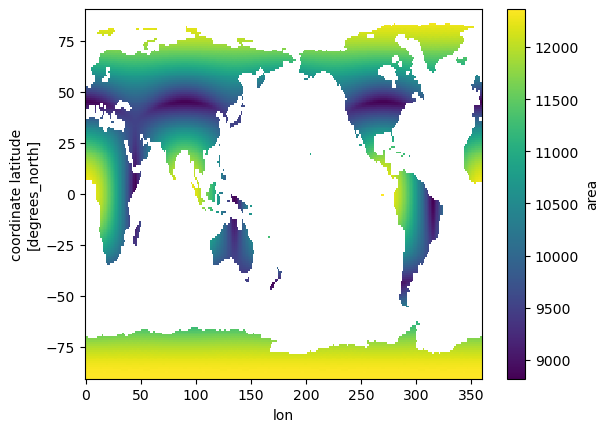

In [14]:
ds_out_con.area.plot() ;

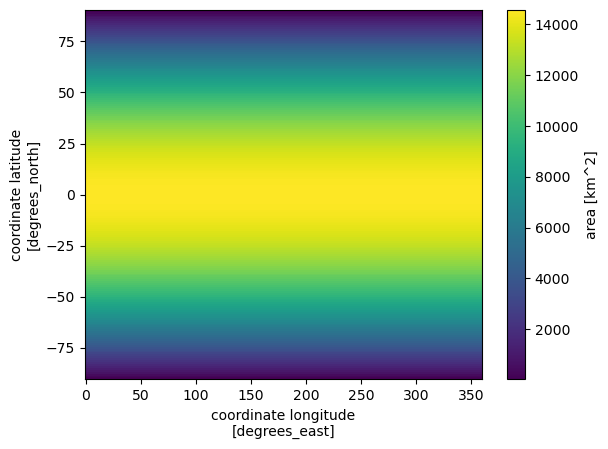

In [15]:
fv_t232.area.plot() ;

----
### Make plots
---

First we'll look at ocean masks and regridded data
Using the correct destination land mask gives nicer coastlines 

Text(0.5, 1.0, 'bilinear remapping, dest mask')

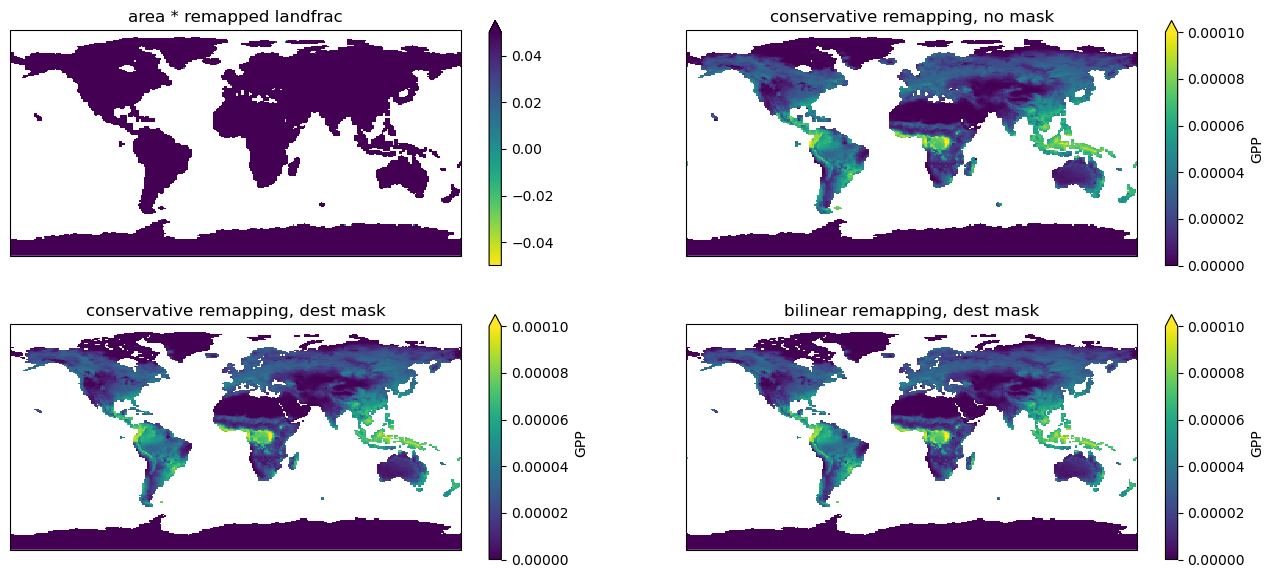

In [16]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw=dict(projection=ccrs.PlateCarree()),
                        figsize=(16,7))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

(fv_t232.area*ds_out_con.landfrac).plot(ax=axs[0],vmin=0, vmax=0, cmap='viridis_r') 
axs[0].set_title('area * remapped landfrac')


ds_out_con.GPP.mean('time').plot(ax=axs[1],vmin=0, vmax=1e-4)
axs[1].set_title('conservative remapping, no mask')

ds_out_con.GPP.mean('time').where(fv_t232.landfrac>0).plot(ax=axs[2],vmin=0, vmax=1e-4)
axs[2].set_title('conservative remapping, dest mask')

# Mask out coasts based on land mask
ds_out_bilin.GPP.mean('time').plot(ax=axs[3],vmin=0, vmax=1e-4)
axs[3].set_title('bilinear remapping, dest mask')

#for a in axs:
#    a.coastlines() ;

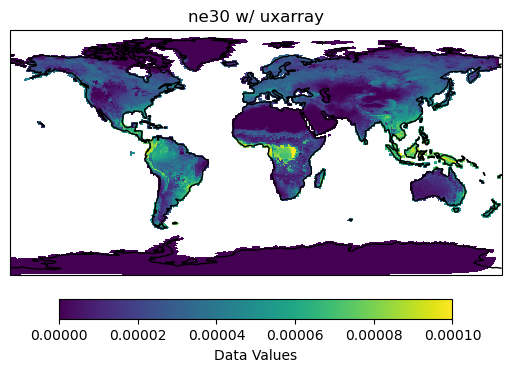

In [17]:
# Look at raw data too using uxarray
transform = ccrs.PlateCarree()
projection = ccrs.PlateCarree()

#projection = ccrs.Orthographic(central_latitude=90)
# TODO, calculate time mean with correct weights
dc = ds0["GPP"].mean('time').to_polycollection(projection=projection, override=True)
dc.set_antialiased(False)
dc.set_transform(transform)
dc.set_antialiased(False)
dc.set_clim(vmin=0, vmax=1e-4)

fig, ax = plt.subplots(
    1,
    1,
    figsize=(5, 5),
    facecolor="w",
    constrained_layout=True,
    subplot_kw=dict(projection=projection),
)

# add geographic features
ax.add_feature(cfeature.COASTLINE)

ax.add_collection(dc)
ax.set_global()
cbar = plt.colorbar(dc, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Data Values')

plt.title("ne30 w/ uxarray") ;

In [18]:
## Sample subplots with uxarray!
dc0 = ds0["GPP"].mean('time').to_polycollection(projection=projection, override=True)
dc0.set_antialiased(False)
dc0.set_transform(transform)
dc0.set_clim(vmin=0, vmax=1e-4)
dc2 = ds0["GPP"].mean('time').to_polycollection(projection=projection, override=True)
dc2.set_antialiased(False)
dc2.set_transform(transform)
dc2.set_clim(vmin=0, vmax=1e-4)

dc1 = ds0["area"].to_polycollection(projection=projection, override=True)
dc1.set_antialiased(False)
dc0.set_transform(transform)

fig, axs = plt.subplots(
    2,
    2,
    figsize=(16, 8),
    facecolor="w",
    constrained_layout=True,
    subplot_kw=dict(projection=projection),
)
axs=axs.flatten()

axs[0].add_collection(dc0)
axs[0].set_title(ds0.GPP.attrs['long_name']) ;

axs[1].add_collection(dc1)
axs[1].set_title(ds0.area.attrs['long_name']) ;

axs[2].add_collection(dc2)
axs[2].set_title(ds0.GPP.attrs['long_name']) ;

cbar1 = plt.colorbar(dc1, ax=axs[1], orientation='vertical', pad=0.05, shrink=0.8)
cbar1.set_label(ds0.area.attrs['units'])
cbar2 = plt.colorbar(dc2, ax=axs[2], orientation='horizontal', pad=0.05, shrink=0.8)
cbar2.set_label(ds0.GPP.attrs['units'])

for a in axs:
    a.set_global()
    a.add_feature(cfeature.COASTLINE)

ValueError: Data Variable must be 1-dimensional, with shape 48600 for face-centered data.

---------
### Subsetting data for Regional plots
Example at https://uxarray.readthedocs.io/en/latest/user-guide/subset.html
1. Look at test data, so see how coastlines are handled
2. Look at regional fluxes and compare raw and regridded data
3. Since climatologies weren't identical, tried weighting fluxes by source landfrac too, but these results don't look great.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
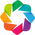

In [19]:
import holoviews as hv
plot_opts = {"width": 700, "height": 350}
hv.extension("bokeh")
warnings.filterwarnings("ignore")

In [20]:
plot_opts = {"width": 700, "height": 400}
clim = (np.nanmin(ds0["GPP"].values), np.nanmax(ds0["GPP"].values))
print(clim)
features = gf.coastline(
    projection=ccrs.PlateCarree(), line_width=1, scale="110m"
) #* gf.states(projection=ccrs.PlateCarree(), line_width=1, scale="110m")

(0.0, 0.0001671932)


In [21]:
# This takes a long time to plot, we'll skip it for now
#ds0["test"][0].plot.polygons(
#    title="Global Grid", **plot_opts
#) * features

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
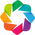

:Overlay
   .Polygons.I  :Polygons   [x,y]   (test)
   .Coastline.I :Feature   [Longitude,Latitude]

In [22]:
# set the bounding box
lon_bounds = (105, 145)
lat_bounds = (25, 58)
# elements include nodes, edge centers, or face centers) 
element = 'face centers'

bbox_subset_nodes = ds0["test"][5].subset.bounding_box(
    lon_bounds, lat_bounds, element=element
)
bbox_subset_nodes.plot.polygons(
    cmap='viridis',
    title="Bounding Box Subset ("+element+")",
    **plot_opts,
) * features

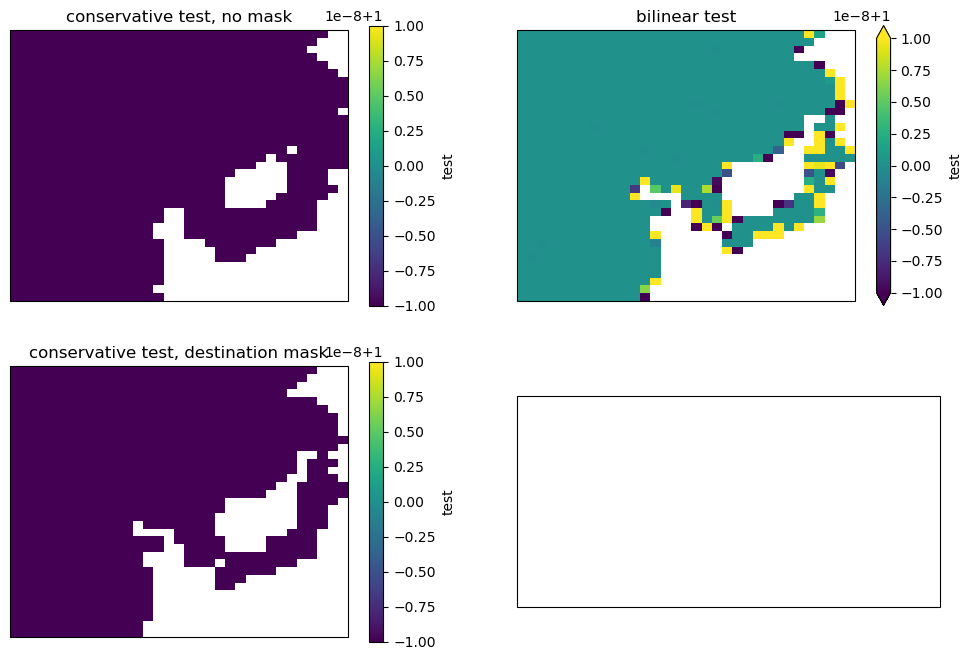

In [23]:
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw=dict(projection=ccrs.PlateCarree()),
                        figsize=(12,8))
axs=axs.flatten()
# These differences around the coast seem pretty tiny, again within rounding error?
ds_out_con.test.isel(time=0)\
  .sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0],lat_bounds[1]))\
  .plot(vmin=1-1e-8, vmax=1+1e-8, ax=axs[0])

ds_out_bilin.test.isel(time=0)\
  .sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0],lat_bounds[1]))\
  .plot(vmin=1-1e-8, vmax=1+1e-8, ax=axs[1]) ;

ds_out_con.test.isel(time=0).where(fv_t232.landfrac>0)\
  .sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0],lat_bounds[1]))\
  .plot(vmin=1-1e-8, vmax=1+1e-8, ax=axs[2])

axs[0].set_title('conservative test, no mask')
axs[1].set_title('bilinear test') ;
axs[2].set_title('conservative test, destination mask') ;

#### Now look at regional fluxes
- Not sure if bounding boxes are necessarily identical in unstructured and regular grid.
- Fluxes still don't look the same when focusing on a few islands, but overall not unreasonable
- What level of difference are we OK tolerating?

In [24]:
# elements include nodes, edge centers, or face centers) 
element = 'face centers'
region = 'Hawaii'
month = 6
# set the bounding box
plot_opts = {"width": 700, "height": 400}

if region == 'Global':
    lat_bounds = (-90, 90)
    lon_bounds = (-180, 180)
    lon_bounds2 = (0, 360)
elif region == 'East Asia':
    lat_bounds = (23, 58)
    lon_bounds = (110, 150)
    lon_bounds2 = (110, 150)
elif region == 'Polar':
    lat_bounds = (60, 90)
    lon_bounds = (-180, 180)
    lon_bounds2 = (0, 360)
elif region == 'Hawaii':
    lat_bounds = (17, 25)
    lon_bounds = (-162, -153)
    lon_bounds2 = ((360-162), (360-153)) 
elif region == 'Amazon':
    lat_bounds = (-10, 0)
    lon_bounds = (-70, -50)
    lon_bounds2 = ((290), (310)) 
elif region == 'New Zeland':
    lat_bounds = (-50, -33)
    lon_bounds = (160, 179)
    lon_bounds2 = (160, 180)
elif region == 'South America':
    lat_bounds = (-57, 13)
    lon_bounds = (-85, -30)
    lon_bounds2 = ((360-85), (360-30))
    plot_opts = {"width": 700, "height": 700}  


bbox_subset_nodes = ds0["GPP"][month].subset.bounding_box(
    lon_bounds, lat_bounds, element=element
)

In [25]:
#if region != "New Zeland" comment out features below 
bbox_subset_nodes.plot.polygons(
    clim=clim, 
    cmap='viridis',
    title=region + " Bounding Box Subset ("+element+" Query)",
    **plot_opts,
) * features

:Overlay
   .Polygons.I  :Polygons   [x,y]   (GPP)
   .Coastline.I :Feature   [Longitude,Latitude]

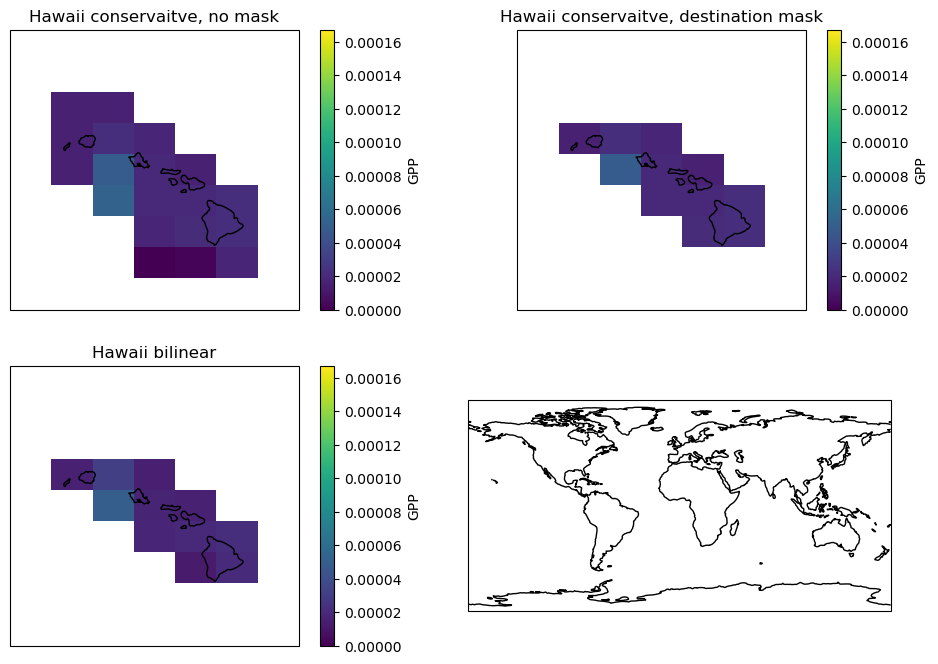

In [26]:
if region == "New Zeland":
    fig, axs = plt.subplots(nrows=2,ncols=2,
                    figsize=(12,8))
else:
    fig, axs = plt.subplots(nrows=2,ncols=2,
                    subplot_kw=dict(projection=ccrs.PlateCarree()),
                    figsize=(12,8))
axs=axs.flatten()
ds_out_con.GPP.isel(time=month)\
  .sel(lon=slice(lon_bounds2[0],lon_bounds2[1]),lat=slice(lat_bounds[0],lat_bounds[1]))\
  .plot(vmin=clim[0],vmax=clim[1], ax=axs[0]) 
axs[0].set_title(region + ' conservaitve, no mask')

ds_out_con.GPP.isel(time=month).where(fv_t232.landfrac>0)\
  .sel(lon=slice(lon_bounds2[0],lon_bounds2[1]),lat=slice(lat_bounds[0],lat_bounds[1]))\
  .plot(vmin=clim[0],vmax=clim[1], ax=axs[1]) 
axs[1].set_title(region + ' conservaitve, destination mask')


ds_out_bilin.GPP.isel(time=month)\
  .sel(lon=slice(lon_bounds2[0],lon_bounds2[1]),lat=slice(lat_bounds[0],lat_bounds[1]))\
  .plot(vmin=clim[0],vmax=clim[1], ax=axs[2]) 
axs[2].set_title(region + ' bilinear') ;

if region != "New Zeland":
    for a in axs:
        a.coastlines()

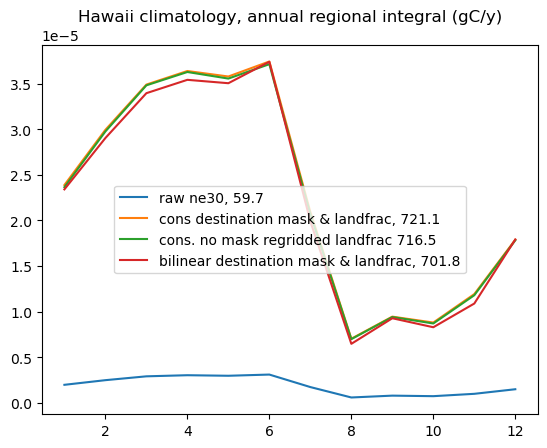

59.7
721.1
716.506
717.332
701.8


In [27]:
# elements include nodes, edge centers, or face centers) 
element = 'face centers'
element = 'nodes'

var = 'GPP'
bbox_var = ds0[var].subset.bounding_box(
    lon_bounds, lat_bounds, element=element)

bbox_area = ds0["area"].subset.bounding_box(
    lon_bounds, lat_bounds, element=element)

bbox_landfrac = ds0["landfrac"].subset.bounding_box(
    lon_bounds, lat_bounds, element=element)

# Area weighting
bbox_wgt = bbox_area * bbox_landfrac /  ((bbox_area * bbox_landfrac).sum())
y = (bbox_var * bbox_wgt).sum('n_face').values
x = bbox_var['time'].values

plt.plot(x, y, label = 'raw ne30, ' + str(np.round(y.mean() * spy, 1))) 

#repeat for regridded climo
bbox_area_r = fv_t232['area'].sel(lon=slice(lon_bounds2[0],lon_bounds2[1]),lat=slice(lat_bounds[0],lat_bounds[1])) 
bbox_landfrac_r = fv_t232['landfrac'].sel(lon=slice(lon_bounds2[0],lon_bounds2[1]),lat=slice(lat_bounds[0],lat_bounds[1])) 
bbox_wgt_r = bbox_area_r * bbox_landfrac_r /  ((bbox_area_r * bbox_landfrac_r).sum())

# Better with destination area
bbox_area_rB = ds_out_con['area'].sel(lon=slice(lon_bounds2[0],lon_bounds2[1]),lat=slice(lat_bounds[0],lat_bounds[1])) 
bbox_landfrac_rB = ds_out_con['landfrac'].sel(lon=slice(lon_bounds2[0],lon_bounds2[1]),lat=slice(lat_bounds[0],lat_bounds[1])) 
bbox_landfrac_rC = ds_out_con['landfrac'].where(fv_t232['landmask']==1).sel(lon=slice(lon_bounds2[0],lon_bounds2[1]),lat=slice(lat_bounds[0],lat_bounds[1])) 
bbox_wgt_rB = bbox_area_r * bbox_landfrac_rB /  ((bbox_area_r * bbox_landfrac_rB).sum())
bbox_wgt_rC = bbox_area_r * bbox_landfrac_rC /  ((bbox_area_r * bbox_landfrac_rC).sum())

bbox_var_r = ds_out_con[var].sel(lon=slice(lon_bounds2[0],lon_bounds2[1]),lat=slice(lat_bounds[0],lat_bounds[1])) 
y_r = (bbox_var_r * bbox_wgt_r).sum(['lat','lon']).values
y_rB = (bbox_var_r * bbox_wgt_rB).sum(['lat','lon']).values
y_rC = (bbox_var_r * bbox_wgt_rC).sum(['lat','lon']).values
plt.plot(x, y_r, label = 'cons destination mask & landfrac, ' + str(np.round(y_r.mean()* spy,1))) 
plt.plot(x, y_rB, label = 'cons. no mask regridded landfrac ' + str(np.round(y_rB.mean()* spy,1))) 

bbox_var_r2 = ds_out_bilin[var].sel(lon=slice(lon_bounds2[0],lon_bounds2[1]),lat=slice(lat_bounds[0],lat_bounds[1])) 
y_r2 = (bbox_var_r2 * bbox_wgt_r).sum(['lat','lon']).values
plt.plot(x, y_r2,
         label= 'bilinear destination mask & landfrac, ' + str(np.round(y_r2.mean()* spy,1))) 

plt.title(region + ' climatology, annual regional integral (gC/y)')
plt.legend()
plt.show();
# Print mean annual flux from region (not time weighted correctly)
print(np.round(y.mean()* spy,1))
print(np.round(y_r.mean()* spy,1))
print(np.round(y_rB.mean()* spy,3))
print(np.round(y_rC.mean()* spy,3))
print(np.round(y_r2.mean()* spy,1))


In [28]:
print(bbox_landfrac_r.sum()) #destination land frac sum

bbox_landfrac_rB.sum() #regridded land frac sum
#bbox_wgt_rC.plot(vmax=0.18,vmin=0.04)

<xarray.DataArray 'landfrac' ()> Size: 4B
array(1.7618376, dtype=float32)


<xarray.DataArray 'landfrac' ()> Size: 4B
array(1.762814, dtype=float32)

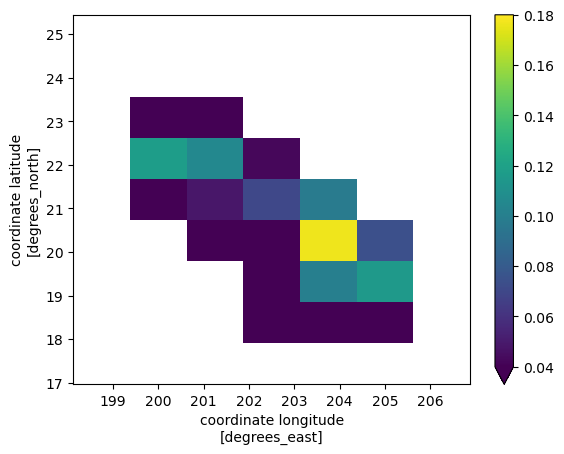

In [29]:
bbox_wgt_rB.plot(vmax=0.18,vmin=0.04)

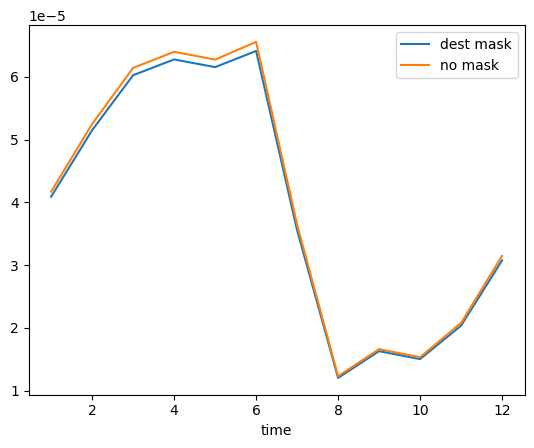

In [30]:
(bbox_landfrac_rC*bbox_var_r).sum(['lat','lon']).plot(label='dest mask')
(bbox_landfrac_rB*bbox_var_r).sum(['lat','lon']).plot(label='no mask')
plt.legend();

In [31]:
 print((bbox_area_r * bbox_landfrac_r).sum().values)
 print((bbox_area * bbox_landfrac).sum().values)

24003.926
288054.2


In [32]:
mesh0

'/glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc'